# Explore places associated with collection objects

In this notebook we'll explore the spatial dimensions of the `object` data. Where were objects created or collected? To do that we'll extract the nested spatial data, see what's there, and create a few maps.

[See here](exploring_object_records.ipynb) for an introduction to the `object` data, and [here to explore objects over time](explore_collection_object_over_time.ipynb).

If you haven't already, you'll need to [harvest the `object` data](harvest_records.ipynb) first.

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>

<p><b>Is this thing on?</b> If you can't edit or run any of the code cells, you might be viewing a static (read only) version of this notebook. Click here to <a href="https://mybinder.org/v2/gh/GLAM-Workbench/trove-newspapers/master?filepath=visualise-searches-over-time.ipynb">load a <b>live</b> version</a> running on Binder.</p>

</div>

## Import what we need

In [1]:
import pandas as pd
from ipyleaflet import Map, Marker, Popup, MarkerCluster, basemap_to_tiles, CircleMarker
import ipywidgets as widgets
from tinydb import TinyDB, Query
import reverse_geocode
from pandas.io.json import json_normalize
import altair as alt
from IPython.display import display, HTML, FileLink
from vega_datasets import data as vega_data
import country_converter as coco
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Are you using JupyterLab or the classic Jupyter notebook?
# If you're using the classic notebook, uncomment the following line to make sure Altair charts appear as expected!

# alt.renderers.enable('notebook')

## Load the harvested data

In [3]:
# Get the JSON data from the local db
db = TinyDB('nma_object_db.json')
records = db.all()
Object = Query()

In [4]:
# Convert to a dataframe
df = pd.DataFrame(records)

## How many different places are referred to in object records?

Places are linked to object records through the `spatial` field. One object record can be linked to multiple places. Let's get a list of all the places linked to object records.

First we'll use `json_normalize()` to extract the nested lists in the `spatial` field, creating one row for every linked place.

In [5]:
df_places = json_normalize(df.loc[df['spatial'].notnull()].to_dict('records'), record_path='spatial', meta=['id'], record_prefix='spatial_')
df_places.head()

,spatial_id,spatial_type,spatial_title,spatial_roleName,spatial_interactionType,spatial_geo,spatial_description,id
0,693,Place,"Ernabella, South Australia, Australia",Place made,Production,"-26.2642,132.176",NaN,124081
1,1187,Place,Mandiupi,NaN,Production,NaN,NaN,20174
2,333,Place,"Broken Hill, New South Wales, Australia",Place collected,NaN,NaN,NaN,188741
3,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,Production,"-32.67,152.23",NaN,42084
4,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,NaN,NaN,NaN,42084


This list will include many duplicates as more than one object will be linked to a particular place. Let's drop duplicates based on the `spatial_id` and count how many there are.

In [6]:
df_places.drop_duplicates(subset=['spatial_id']).shape[0]

3325

Let's put the places on a map. First, we'll filter the records to show only those that have geo-coordinates, and then remove the duplicates as before.

In [7]:
df_places_with_geo = df_places.loc[df_places['spatial_geo'].notnull()].drop_duplicates(subset=['spatial_id'])

You might have noticed that the `spatial_geo` field contains the latitude and longitude, separated by a comma. Let's split the coordinates into separate columns.

In [8]:
df_places_with_geo[['lat', 'lon']] = df_places_with_geo['spatial_geo'].str.split(',', expand=True)
df_places_with_geo.head()

,spatial_id,spatial_type,spatial_title,spatial_roleName,spatial_interactionType,spatial_geo,spatial_description,id,lat,lon
0,693,Place,"Ernabella, South Australia, Australia",Place made,Production,"-26.2642,132.176",NaN,124081,-26.2642,132.176
3,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,Production,"-32.67,152.23",NaN,42084,-32.67,152.23
12,80019,Place,"Central Australia, Northern Territory, Australia",NaN,Production,"-24.3617,133.735",NaN,6840,-24.3617,133.735
16,4329,Place,"Mount Hagen, Western Highlands Province, Papua...",Place made,Production,"-5.8581,144.243",NaN,203086,-5.8581,144.243
27,1883,Place,"Tasmania, Australia",NaN,Production,"-41.9253,146.497",NaN,70975,-41.9253,146.497


Ok, let's make a map!

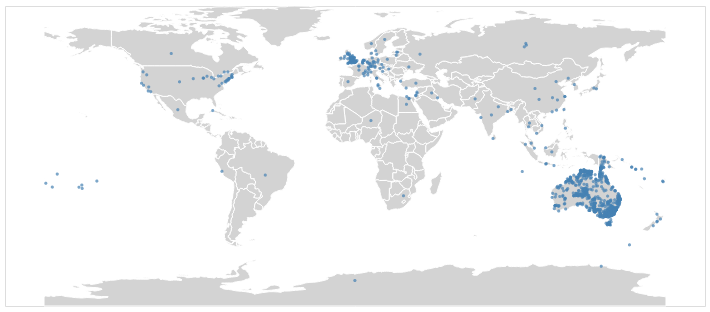

In [9]:
# This loads the country boundaries data
countries = alt.topo_feature(vega_data.world_110m.url, feature='countries')

# First we'll create the world map using the boundaries
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# Then we'll plot the positions of places using circles
points = alt.Chart(df_places_with_geo).mark_circle(
    
    # Style the circles
    size=10,
    color='steelblue'
).encode(
    
    # Provide the coordinates
    longitude='lon:Q',
    latitude='lat:Q',
    
    # More info on hover
    tooltip=[alt.Tooltip('spatial_title', title='Place')]
).properties(width=700)

# Finally we layer the plotted points on top of the backgroup map
alt.layer(background, points)

## What's missing?

In order to put the places on a map, we filtered out places that didn't have geo-coordinates. But how many of the linked places have coordinates?

In [10]:
'{:.2%} of linked places have geo-coordinates'.format(df_places_with_geo.shape[0] / df_places.drop_duplicates(subset=['spatial_id']).shape[0])

'32.09% of linked places have geo-coordinates'

Hmmm, so a majority of linked places are actually missing from our map. Let's dig a bit deeper into the `spatial` records to see if we can work out why there are only geo-coordinates for some records.

## Relationships to places

The relationships between places and objects are described in the `spatial_roleName` column. Let's see what's in there.

In [11]:
df_places['spatial_roleName'].value_counts()

Place collected                   14497
Associated place                  12275
Place made                         5414
Place depicted                     4033
Place of event                     2150
Place used                         1827
Place created                      1718
Place of use                       1553
Subject                            1285
Place of publication               1275
Place printed                       614
Place of issue                      604
Place of production                 574
Place photographed                  475
Place worn                          364
Place compiled                      205
Place written                       174
Content created                     147
Place designed                      122
Place of execution                  113
Place Made                           66
Place purchased                      57
Place of restoration                 13
Place of component manufacture       10
Place of Origin                       9


As you can see there's quite a few variations in format and capitalisation which makes it hard to aggregate. Fortunately the NMA has already applied some normalisation, grouping together all of the relationships that relate to creation or production. These are identified by the value 'Production' in the `interactionType` field. Let's see which of the `roleName` values are aggregated by `interactionType`.

In [12]:
df_places.loc[(df_places['spatial_interactionType'] == 'Production')]['spatial_roleName'].value_counts()

Place made                        5414
Place created                     1718
Place of publication              1275
Place printed                      614
Place of production                574
Place of issue                     542
Place photographed                 475
Place compiled                     205
Place written                      174
Content created                    147
Place designed                     122
Place of execution                 113
Place Made                          66
Place of restoration                13
Place of component manufacture      10
place made                           6
Place of conversion                  4
Place assembled                      4
Place of Execution                   1
Place of Publication                 1
place of Publication                 1
Name: spatial_roleName, dtype: int64

How many of the places relate to production?

In [13]:
df_places.loc[(df_places['spatial_interactionType'] == 'Production')].shape[0]

16706

Looking at the numbers above, you might think that the counts by `roleName` don't seem to add up to the total number with `interactionType` set to 'Production'. Let's check by finding the number of 'Production' records that have no `roleName`.

In [14]:
df_places.loc[(df_places['spatial_interactionType'] == 'Production') & (df_places['spatial_roleName'].isnull())].shape[0]

5227

So, quite a lot of the places with a 'Production' relationship have no `roleName`. Let's look at a few.

In [15]:
df_places.loc[(df_places['spatial_interactionType'] == 'Production') & (df_places['spatial_roleName'].isnull())].head()

,spatial_id,spatial_type,spatial_title,spatial_roleName,spatial_interactionType,spatial_geo,spatial_description,id
1,1187,Place,Mandiupi,NaN,Production,NaN,NaN,20174
3,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,Production,"-32.67,152.23",NaN,42084
12,80019,Place,"Central Australia, Northern Territory, Australia",NaN,Production,"-24.3617,133.735",NaN,6840
25,621,Place,"Djinmalinjera, Northern Territory, Australia",NaN,Production,NaN,NaN,19877
27,1883,Place,"Tasmania, Australia",NaN,Production,"-41.9253,146.497",NaN,70975


Hmmm, that seems rather odd, but it shouldn't affect us too much. It just makes you wonder how those 'Production' values were set.

## Created vs Collected

So according to the data above, it seems we have two major ways of categorising the relationships between places and objects. We can filter the `roleName` field by 'Place collected', or we can filter `interactionType` by 'Production'. Is there any overlap between these two groups?

In [16]:
# How many records have both an interactionType equal to 'Production' and a roleName equal to 'Place collected'?
df_places.loc[(df_places['spatial_interactionType'] == 'Production') & (df_places['spatial_roleName'] == 'Place collected')].shape[0]

0

Nope, no overlap. These two groups don't capture all of the place relationships, but they do represent distinct types of relationships and are roughly equal in size. But before we start making more maps, let's see how many places in each group have geo-coordinates.

First the 'created' places:

In [17]:
created_count = df_places.loc[(df_places['spatial_interactionType'] == 'Production')].shape[0]
created_geo_count = df_places.loc[(df_places['spatial_interactionType'] == 'Production') & (df_places['spatial_geo'].notnull())].shape[0]
print('{} of {} places ({:.2%}) with a "created" relationship have coordinates'.format(created_geo_count, created_count, created_geo_count / created_count))

16417 of 16706 places (98.27%) with a "created" relationship have coordinates


Now the 'collected' places:

In [18]:
collected_count = df_places.loc[(df_places['spatial_roleName'] == 'Place collected')].shape[0]
collected_geo_count = df_places.loc[(df_places['spatial_roleName'] == 'Place collected') & (df_places['spatial_geo'].notnull())].shape[0]
print('{} of {} places ({:.2%}) with a "collected" relationship have coordinates'.format(collected_geo_count, collected_count, collected_geo_count / collected_count))

0 of 14497 places (0.00%) with a "collected" relationship have coordinates


Ok... So in answer to our question above about what's missing, it seems that only places with a 'created' relationship have geo-coordinates. Let's see if we can fix that so we can map both 'created' and 'collected' records.

## Enriching the place data

As well as the place data that's embedded in object records, the NMA provides access to all of the place records in its system. These [can be harvested](harvest_records.ipynb) from the `/place` endpoint. Assuming that you've harvested all the place records, we can now use them to enrich the object records.

First we'll load all the places records.

In [19]:
db_places = TinyDB('nma_place_db.json')
place_records = db_places.all()
df_all_places = pd.DataFrame(place_records)

We're going to merge the place records with the object records, but before we do that, let's see if we can add information about country to the records.

The `spatial_title` field is a string that often (but not always) includes the country as well as the place name. But it doesn't seem like a reliable way of identifying countries. An alternative is to use the geo-coordinates. Through a process known as reverse-geocoding, we can lookup the country that contains a set of coordinates. To do this we're going to use the [reverse-geocode package](https://pypi.org/project/reverse-geocode/).

In [20]:
def find_country(row):
    '''
    Use reverse-geocode to get country details for a set of coordinates.
    '''
    try:
        coords = tuple([float(c) for c in row['geo'].split(',')]),
        location = reverse_geocode.search(coords)
        country = [location[0]['country_code'], location[0]['country']]
    except AttributeError:
        country = []
    return pd.Series(country)
    
df_all_places[['country_code', 'country']] = df_all_places.apply(find_country, axis=1)                     

Did it work? Let's look at the `country` values.

In [21]:
df_all_places['country'].value_counts()

Australia                           2954
United Kingdom                       185
United States                        139
Papua New Guinea                      77
Italy                                 38
                                    ... 
Niger                                  1
Nauru                                  1
Lao People's Democratic Republic       1
Kuwait                                 1
Cuba                                   1
Name: country, Length: 126, dtype: int64

Now it's time to merge the place data we extracted from the object records, with the complete set of place records. By linking records using the place `id`, we can append the information from the place records to the object records.

In [22]:
# Merging on the place id in each dataframe -- in the objects data it's 'spatial_id', in the places it's just 'id'
df_places_merged = pd.merge(df_places, df_all_places, how='left', left_on='spatial_id', right_on='id')
df_places_merged.head()

,spatial_id,spatial_type,spatial_title,spatial_roleName,spatial_interactionType,spatial_geo,spatial_description,id_x,id_y,type,title,geo,country_code,country
0,693,Place,"Ernabella, South Australia, Australia",Place made,Production,"-26.2642,132.176",NaN,124081,693,place,"Ernabella, South Australia, Australia","-26.2642,132.176",AU,Australia
1,1187,Place,Mandiupi,NaN,Production,NaN,NaN,20174,1187,place,Mandiupi,NaN,NaN,NaN
2,333,Place,"Broken Hill, New South Wales, Australia",Place collected,NaN,NaN,NaN,188741,333,place,"Broken Hill, New South Wales, Australia","-31.95,141.45",AU,Australia
3,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,Production,"-32.67,152.23",NaN,42084,383,place,"Cabbage Tree Island, New South Wales, Australia","-32.67,152.23",AU,Australia
4,383,Place,"Cabbage Tree Island, New South Wales, Australia",NaN,NaN,NaN,NaN,42084,383,place,"Cabbage Tree Island, New South Wales, Australia","-32.67,152.23",AU,Australia


The point of this was to try and get geo-cordinates for more of the places in the object records. Let's see if it worked by repeating our check on 'collected' places. Note that the appended field is `geo` rather than `spatial_geo`.

In [23]:
collected_count = df_places_merged.loc[(df_places_merged['spatial_roleName'] == 'Place collected')].shape[0]
collected_geo_count = df_places_merged.loc[(df_places_merged['spatial_roleName'] == 'Place collected') & (df_places_merged['geo'].notnull())].shape[0]
print('{} of {} places ({:.2%}) with a "collected" relationship have coordinates'.format(collected_geo_count, collected_count, collected_geo_count / collected_count))

14406 of 14497 places (99.37%) with a "collected" relationship have coordinates


Huzzah! Now we have geo-coordinates for almost all of the 'collected' places. Let's split the `geo` field into lats and lons as before.

In [24]:
df_places_merged[['lat', 'lon']] = df_places_merged['geo'].str.split(',', expand=True)

## Objects by country

Now that we have a `country_code` column we can use it to filter our data. For example, let's look at places where objects were created in Australia.

First we'll filter our data by `interactionType` and `country_code`.

In [25]:
df_created_aus = df_places_merged.loc[(df_places_merged['spatial_interactionType'] == 'Production') & (df_places_merged['country_code'] == 'AU')]

Now we can create a map. Note that we're changing the map layer in this chart to use just Australian boundaries, not the world.

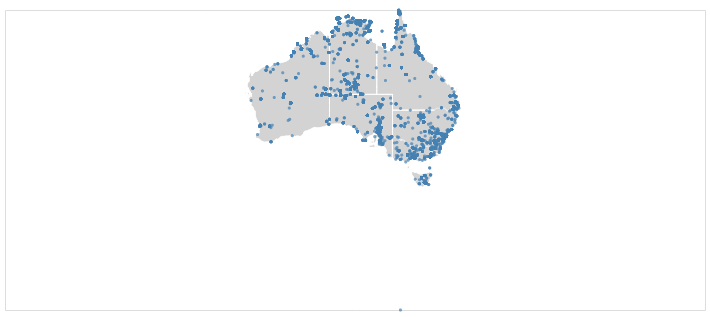

In [26]:
# Load Australian boundaries
australia = alt.topo_feature('https://raw.githubusercontent.com/GLAM-Workbench/trove-newspapers/master/data/aus_state.geojson', feature='features')

# Create the map of Australia using the boundaries
aus_background = alt.Chart(australia).mark_geoshape(
    
    # Style the map
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# Plot the places
points = alt.Chart(df_created_aus).mark_circle(
    
    # Style circle markers
    size=10,
    color='steelblue'
).encode(
    
    # Set position of each place using lat and lon
    longitude='lon:Q',
    latitude='lat:Q',
    
    # More details on hover
    tooltip=[alt.Tooltip('spatial_title', title='Place'), 'lat', 'lon']
).properties(width=700)

# Combine map and points
alt.layer(aus_background, points)

Hmmm, what's with all that white space at the bottom? If you look closely, you'll see one blue dot right at the bottom of the chart. It's Commonwealth Bay in the Australian Antarctic Territory – technically part of Australia, but perhaps not what we expected. If we want our map centred on the Australian continent, we can filter out points with a latitude of less than -50.

Pandas is fussy about comparing different types of things, so let's make sure it knows that the `lat` field contains floats.

In [27]:
df_places_merged['lat'] = df_places_merged['lat'].astype('float')

Now we can filter the data.

In [28]:
df_created_aus = df_places_merged.loc[(df_places_merged['spatial_interactionType'] == 'Production') & (df_places_merged['country_code'] == 'AU') & (df_places_merged['lat'] > -50)]

And update our chart.

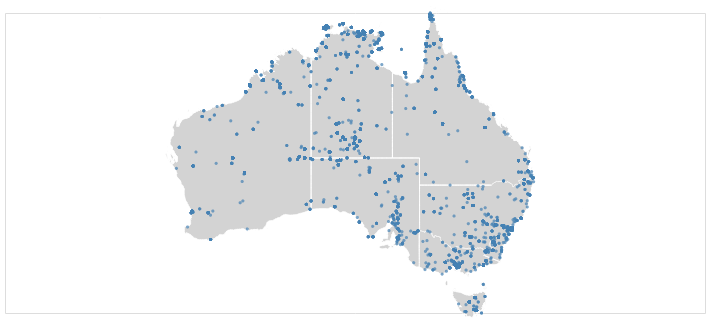

In [29]:
# Plot the places
points = alt.Chart(df_created_aus).mark_circle(
    
    # Style circle markers
    size=10,
    color='steelblue'
).encode(
    
    # Set position of each place using lat and lon
    longitude='lon:Q',
    latitude='lat:Q',
    
    # More details on hover
    tooltip=[alt.Tooltip('spatial_title', title='Place'), 'lat', 'lon']
).properties(width=700)

# Combine map and points
alt.layer(aus_background, points)

## Created vs Collected – second try

Now we have locations for the 'collected' records we can put both 'created' and 'collected' on a map.

To make things a bit easier, let's create a new column which will indicate if the place relationship is either 'collected' or 'created'.

In [30]:
def add_place_status(row):
    '''
    Determine relationship between object and place.
    '''
    if row['spatial_interactionType'] == 'Production':
        status = 'created'
    elif str(row['spatial_roleName']).lower() == 'place collected':
        status = 'collected'
    else:
        status = None
    return status

# Add a new column to the dataframe showing the relationship between place and object
df_places_merged['place_relation'] =  df_places_merged.apply(add_place_status, axis=1)

We'll also filter out places without coordinates.

In [31]:
df_places_merged_with_geo = df_places_merged.loc[(df_places_merged['geo'].notnull()) & (df_places_merged['place_relation'].notnull())]

And remove duplicates, based on both `spatial_id` and the new `place_relation` field.

In [32]:
df_places_merged_with_geo = df_places_merged_with_geo.copy().drop_duplicates(subset=['spatial_id', 'place_relation'])

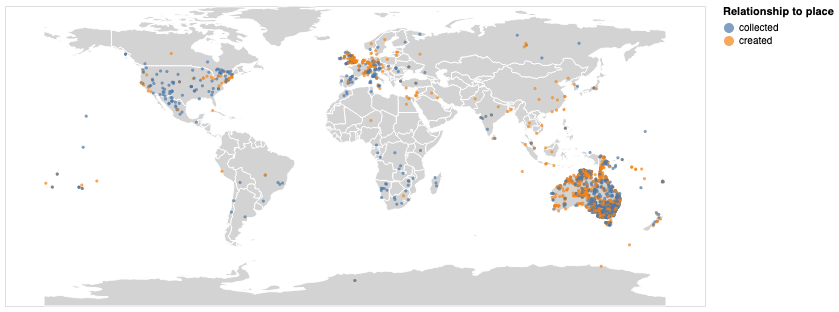

In [33]:
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# Plot the places
points = alt.Chart(df_places_merged_with_geo).mark_circle(
    size=10,
).encode(
    # Plot places by lat and lon
    longitude='lon:Q',
    latitude='lat:Q',
    
    # Details on hover
    tooltip=[alt.Tooltip('spatial_title', title='Place')],
    
    # Color will show whether 'collected' or 'created'
    color=alt.Color('place_relation:N', legend=alt.Legend(title='Relationship to place'))
).properties(width=700)

# Combine map and points
alt.layer(background, points)

## Number of objects associated with places

So far we've only looked at the places themselves, but we can also find out how many objects are associated with each place. To do this, we'll create separate dataframes for our 'created' and 'collected' places, then we'll group them by place and count the number of grouped objects.

First we'll filter out places without coordinates or place relations.

In [34]:
# Filter places
df_created_collected = df_places_merged.loc[(df_places_merged['geo'].notnull()) & (df_places_merged['place_relation'].notnull())]

In [35]:
# New df with created places
df_created = df_created_collected.loc[df_created_collected['place_relation'] == 'created']

# Group created places by place fields -- count the number of grouped records, then convert the results to a new dataframe
df_created_groups = df_created.groupby(by=['spatial_id', 'spatial_title', 'place_relation', 'lat', 'lon'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

# New df with collected places
df_collected = df_created_collected.loc[df_created_collected['place_relation'] == 'collected']

# Group collected places by place fields -- count the number of grouped records, then convert the results to a new dataframe
df_collected_groups = df_collected.groupby(by=['spatial_id', 'spatial_title', 'place_relation', 'lat', 'lon'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

Now we have new dataframes with counts by place and relationship, let's peek inside one.

In [36]:
df_created_groups.head()

,spatial_id,spatial_title,place_relation,lat,lon,count
0,1,"Yogjakarta, Java, Indonesia",created,-7.7956,110.369,2
1,10,"Point Puer, Carnarvon Bay, Tasmania, Australia",created,-43.1500,147.86,2
2,100,"Amoonguna, Northern Territory, Australia",created,-23.7700,133.93,1
3,1001,"Government House, Yarralumla, Canberra, Austra...",created,-35.3014,149.077,2
4,1003,"Kerang, Victoria, Australia",created,-35.7200,143.92,1


Now we can map the results! In this case we'll create two maps, but display them combined with a single legend.

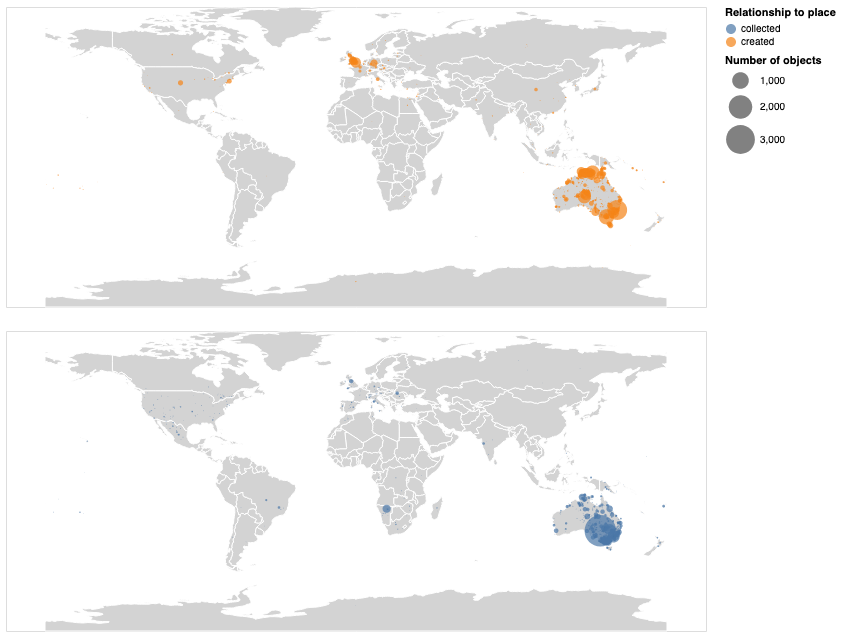

In [37]:
# Create the world map
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# First we'll plot the created places
points = alt.Chart(df_created_groups).mark_circle().encode(
    
    # Position the circles
    longitude='lon:Q',
    latitude='lat:Q',
    
    # Hover for more details
    tooltip=[alt.Tooltip('count:Q', title='Number of objects'), alt.Tooltip('spatial_title', title='Place')],
    
    # Color shows the relationship types
    color=alt.Color('place_relation:N', title='Relationship to place'),
    
    # The size of the circles is determined by the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Number of objects')
    )
).properties(width=700)

# Create a map by combining the background map and the points
created = alt.layer(background, points)

# Now we'll plot the collected places
points = alt.Chart(df_collected_groups).mark_circle().encode(
    
    # Position the circles
    longitude='lon:Q',
    latitude='lat:Q',
    
    # Hover for more details
    tooltip=[alt.Tooltip('count:Q', title='Number of objects'), alt.Tooltip('spatial_title', title='Place')],
    
    # Color shows the relationship types
    color=alt.Color('place_relation:N', title='Relationship to place'),
    
    # The size of the circles is determined by the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Number of objects')
    )
).properties(width=700)

# Create a map by combining the background map and the points
collected = alt.layer(background, points)

# Display the two maps together with a single legend.
created & collected

Why were 243 objects collected in Namibia?

## Focus on Australia

As we did above we can zoom in on Australia by using the `country_code` to filter the data. As before, we then group by place and count the number of objects in each group.

In [38]:
# Filter by created places and limit country to AU
df_created_aus = df_created_collected.loc[(df_created_collected['place_relation'] == 'created') & (df_created_collected['country_code'] == 'AU')& (df_created_collected['lat'] > -50)]

# Group created places by place fields -- count the number of grouped records, then convert the results to a new dataframe
df_created_aus_groups = df_created_aus.groupby(by=['spatial_id', 'spatial_title', 'place_relation', 'lat', 'lon'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

# Filter by collected places and limit country to AU
df_collected_aus = df_created_collected.loc[(df_created_collected['place_relation'] == 'collected') & (df_created_collected['country_code'] == 'AU') & (df_created_collected['lat'] > -50)]

# Group collected places by place fields -- count the number of grouped records, then convert the results to a new dataframe
df_collected_aus_groups = df_collected_aus.groupby(by=['spatial_id', 'spatial_title', 'place_relation', 'lat', 'lon'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

Now we can map the results! As above, we'll create two maps, but display them combined with a single legend.

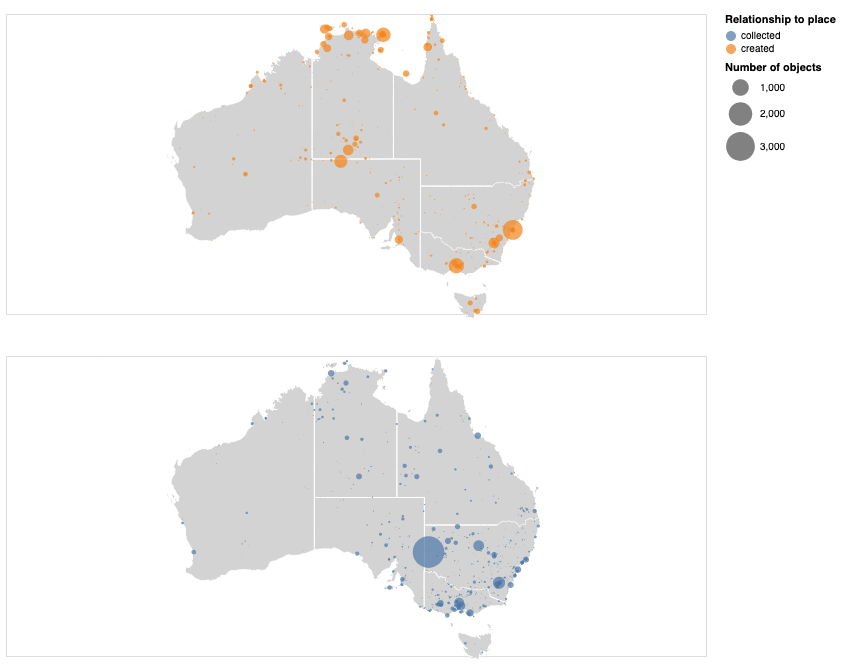

In [39]:
# Make map of Australia
aus_background = alt.Chart(australia).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# Plot points for created places
points = alt.Chart(df_created_aus_groups).mark_circle().encode(
    
    # Postion the markers
    longitude='lon:Q',
    latitude='lat:Q',
    
    # More detail on hover
    tooltip=[alt.Tooltip('count:Q', title='Number of objects'), alt.Tooltip('spatial_title', title='Place')],
    
    # Color determined by relationship type
    color=alt.Color('place_relation:N', title='Relationship to place'),
    
    # Size determined by the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Number of objects')
    )
).properties(width=700)

# Create a map by combining background and points
created_aus = alt.layer(aus_background, points)

# Plot points for collected places
points = alt.Chart(df_collected_aus_groups).mark_circle().encode(

    # Postion the markers
    longitude='lon:Q',
    latitude='lat:Q',
    
    # More detail on hover
    tooltip=[alt.Tooltip('count:Q', title='Number of objects'), alt.Tooltip('spatial_title', title='Place')],
    
    # Color determined by relationship type
    color=alt.Color('place_relation:N', title='Relationship to place'),
    
    # Size determined by the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Number of objects')
    )
).properties(width=700)

# Create a map by combining background and points
collected_aus = alt.layer(aus_background, points)

# Display the two maps together with a single legend.
created_aus & collected_aus

## Number of objects by country

Finally let's look at the number of objects created/collected in each country. In this case we'll group by `country_code` rather than place `id`. Note that because the world boundaries use ISO numeric ids for countries, we have to use [country_converter](https://pypi.org/project/country_converter/) to get the numeric id for each country code and add it to our dataframe. We'll use this field to link the data and the map.

In [40]:
# Group created places by country and count the results
df_created_country_groups = df_created.groupby(by=['country_code', 'country'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

# Create a new field and add the numeric version of the country code using country_converter
df_created_country_groups['numeric'] = df_created_country_groups['country_code'].apply(lambda x: coco.convert(x, to='ISOnumeric'))

# Group collected places by country and count the results
df_collected_country_groups = df_collected.groupby(by=['country_code', 'country'])['id_x'].count().to_frame().reset_index().rename({'id_x': 'count'}, axis=1)

# Create a new field and add the numeric version of the country code using country_converter
df_collected_country_groups['numeric'] = df_collected_country_groups['country_code'].apply(lambda x: coco.convert(x, to='ISOnumeric'))

Now we'll create the choropleth maps. these are a little more complicated as we need to link the country boundaries with the counts of objects.

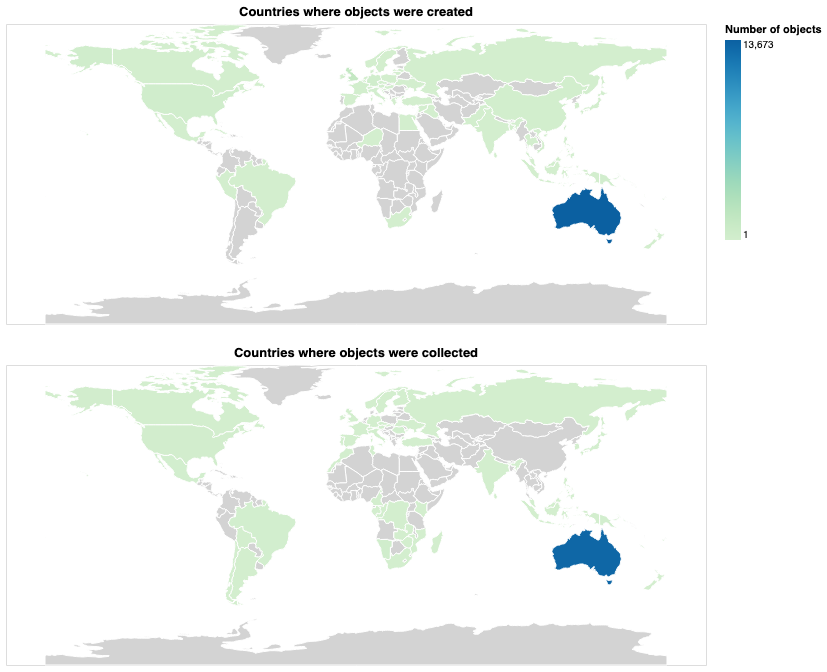

In [41]:
# We'll use the world map as a background to the choropleth, otherwise countries with no objects will be invisible!
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equirectangular').properties(width=700)

# Chart the created numbers by country - once again we use the world boundaries to define countries
choro = alt.Chart(countries).mark_geoshape(
    stroke='white'
).encode(
    
    # Color is determined by the number of objects
    color=alt.Color('count:Q', scale=alt.Scale(scheme='greenblue'), legend=alt.Legend(title='Number of objects')),
    
    # Hover for details
    tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('count:Q', title='Number of objects')]
    
    # This is the critical section that links the map to the object data
).transform_lookup(
    
    # This is the field that contains the country ids in the boundaries file
    lookup='id',
    
    # This is where we link the dataframe with the counts by country
    # The numeric field is the country identifier and will be used to connect data with country
    # We can also need the count and country fields
    from_=alt.LookupData(df_created_country_groups, 'numeric', ['count', 'country'])
).project('equirectangular').properties(width=700, title='Countries where objects were created')

# Create the map by combining the background and the choropleth
created_choro = alt.layer(background, choro)

# Chart the collected numbers by country - once again we use the world boundaries to define countries
choro = alt.Chart(countries).mark_geoshape(
    stroke='white'
).encode(
    
    # Color is determined by the number of objects
    color=alt.Color('count:Q', scale=alt.Scale(scheme='greenblue'), legend=alt.Legend(title='Number of objects')),
    
    # Hover for details
    tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('count:Q', title='Number of objects')]
    
    # This is the critical section that links the map to the object data
).transform_lookup(
    
    # This is the field that contains the country ids in the boundaries file
    lookup='id',
    
    # This is where we link the dataframe with the counts by country
    # The numeric field is the country identifier and will be used to connect data with country
    # We can also need the count and country fields
    from_=alt.LookupData(df_collected_country_groups, 'numeric', ['count', 'country'])
).project('equirectangular').properties(width=700, title='Countries where objects were collected')

# Create the map by combining the background and the choropleth
collected_choro = alt.layer(background, choro)

# Combine the two maps for display
created_choro & collected_choro

## Save counts by country as a CSV file

It might be handy to have a CSV file that shows the count of objects by relationship type and country. Let's combine the two dataframes, clean things up, and save.

In [42]:
# Merge the collected and created country data, linking on country
df_countries = pd.merge(df_created_country_groups, df_collected_country_groups, on=['country_code', 'country', 'numeric'], how='outer')

# Rename columns and fill null values with zeros
df_countries = df_countries.rename({'count_x': 'number_created', 'count_y': 'number_collected'}, axis=1).fillna(0)

# Convert count fields from floats to ints
df_countries[['number_created', 'number_collected']] = df_countries[['number_created', 'number_collected']].astype(int)

# Save to CSV
df_countries[['country_code', 'country', 'number_created', 'number_collected']].to_csv('nma_object_numbers_by_country.csv', index=False)

display(FileLink('nma_object_numbers_by_country.csv'))

/Volumes/Workspace/mycode/glam-workbench/national-museum-australia/notebooks/nma_object_numbers_by_country.csv

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.github.io/).

Work on this notebook was supported by the [Humanities, Arts and Social Sciences (HASS) Data Enhanced Virtual Lab](https://tinker.edu.au/).